# Example: Compute the Probability of Profit for a Put Contract
Suppose we sold a `DTE = 43-day` put option on `AMD,` with a strike price of `K = 145 USD/share`, collecting the mid-point premium of `P = 5.58 USD/share` for the sale. Let's use options data and projections of the `AMD` share price to compute the breakeven point for the contract, i.e., the value of the `AMD` share price where you start to lose money and the probability of profit (PoP) for the contract.

* __What is the probability of profit__? The probability of profit (POP) is the probability that at the expiration of the contract, the share price of the underlying asset $S_{T}$ is at least `0.01` USD/s greater than the breakeven price of the contract.

## Learning objectives
This worked example will familiarize students with probability of profit (PoP) calculations for a put contract. 
* __Prerequisites__: Before we do any calculations, set values for the `AMD` contract used in this example, i.e., observed values for the share price, premium, implied volatility, etc.
* __Task 1: Compute breakeven share price__: Next, we'll use our understanding of options contracts and the problem data to compute the breakeven share price for the example `put` contract.
    * `Check`: Are the computed and observed breakeven points equal?
* __Task 2: Estimate the future share price of the underlying asset__: Next, we'll use two approaches: a risk-neutral geometric Brownian motion and a back-of-the-envelope estimate using the implied volatility. Both methods produce a distribution of future share prices that we can use to compute the probability that the price is above or below the break-even share price.
    * `TODO`: Construct a single asset gbm model of AMD shares assuming a risk-neutral measure using historical volatility. This model can be sampled to produce a future share price distribution.
        * `Check`: Are future GBM share prices log-normally distributed?
    * `TODO`: Construct an approximate future share price projection using the implied volatility.
* __Task 3: Estimate the probability of profit for a AMD put contract__: Using the price distributions computed in _task 2_, we'll calculate the probability of profit for the `put` option from the buyer's and seller's perspectives. Then, we'll compare this with `Delta` for the contract.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites
Before doing anything else, let's set values for our test `put` option, which was gathered on `11-07-24` at approximately 12:20 pm ETS. Let's set the parameters for this `put` contract so we can use them below:

In [5]:
DTE = 43.0; # days to expiration
Sₒ = 148.82; # AMD underlying share price USD/share
IV = 38.11; # implied volatility
Δt = (1/365); # Time step 1-trading day
K = 145.0; # strike price for put contract
P = 5.58; # midpoint premium
B = 139.42; # observed midpoint price for put contract
POP = 0.6825; # probability of profit for short put
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 366; # 6-points per day
Δ_observed_short_put = 0.3818;

Next, we construct contract models for the options in this example. We begin by building an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the [custom build(...) method for this type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). The [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}) takes two arguments: the type to build, and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) containing the strike price `K`, the `premium` paid for the option, the days to expiration `DTE` (units: years), the `sense = 1` (long), the number of contracts in the `copy` field and the implied volatility in the `IV` field.

We save the call option contract model in the `put_option_model` variable:

In [7]:
put_option_model = build(MyAmericanPutContractModel, (
    K = K, 
    premium = P, # mark price
    DTE = (DTE)*Δt,
    sense = 1, # compute greeks of long contract
    copy = 1,
    IV = (IV/100)
)); # contract variables: accessed before market open 2024-06-13

## Task 1: Compute the break-even points for long and short AMD puts
In this task, let's begin by computing the breakeven of the `put` contract. The payoff per share at expiration for a `put` option contract is given by:
$$
\begin{equation}
V_{p}(K,S(T)) = \max\left(K - S(T),~0\right)
\end{equation}
$$
where $K$ denotes the strike price and $S(T)$ is the share price at expiration. The `seller` charges the `buyer` a premium $\mathcal{P}_{p}(K, S(0))$ for each contract. Because we sold this contract, we are in a short position. For the general case, the profit for a put contract is given by:
$$
\begin{equation*}
P_{p}(K,S(T)) = \theta\cdot\left({V_{p}}(K,S(T)) - \mathcal{P}_{p}(K,S(0))\right)
\end{equation*}
$$
where $\theta$ is a direction parameter; $\theta = 1$ if we are `long` the contract, while $\theta = -1$ if we are `short` the contract.

### Breakeven for a put contract:
The breakeven at expiration for both a long or short put contract is the share price $B_{p}(T)$ at expiration such that $P_{c}(K, B_{p}(T)) = 0$. Thus, for our `short AMD put`, the breakeven share price $B_{p}(T)$ USD/share would be:
$$
\begin{equation*}
B_{p} = K - \mathcal{P}_{p}(K,S(0))
\end{equation*}
$$
For the buyer to make money, the share price must fall below the breakeven price $B_{p}$. For the seller to make money, the share price must remain above the breakeven price.

### Visualize
`Unide` the code block below to see how we plotted the profit diagram at expiration for the long and short put positions on `AMD`:

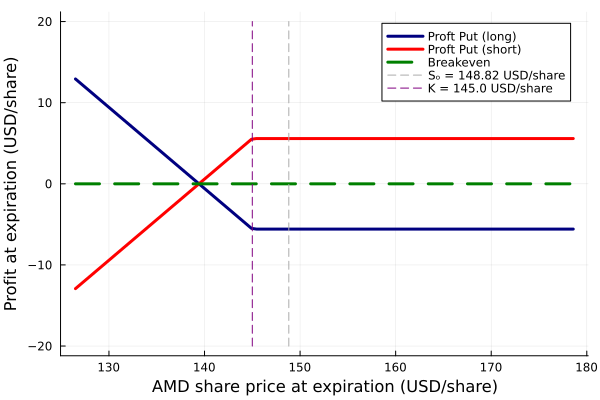

In [10]:
let
    N = 100; # how many points do we want?
    β = range(0.85,stop=1.2, length=N) |> collect;
    ST = Sₒ.*β; # future share price at expiration
    θ = -1; # we are in the short position

    # compute the payoff of the contract -
    payoff_array_long = payoff([put_option_model], ST); # this is always computed for a LONG contract
    profit_array_long = payoff_array_long[:,3] .- P;
    profit_array_short = θ*(payoff_array_long[:,3] .-P);

    # zero line -
    ZL = zeros(N);

    # initial share price line -
    SPL_vertical = range(-20,stop=20,length=N) |> collect;
    SPL_horizontal = Sₒ*ones(N);
    STRIKE_horizontal = K*ones(N);

    # let's visualize
    plot(payoff_array_long[:,1], profit_array_long, c=:navy, lw=3, label="Proft Put (long)", legend=:topright)
    plot!(payoff_array_long[:,1], profit_array_short, c=:red, lw=3, label="Proft Put (short)")
    plot!(payoff_array_long[:,1],ZL, c=:green, lw=3, ls=:dash, label="Breakeven")
    plot!(SPL_horizontal, SPL_vertical, lw=1,c=:gray67,ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    plot!(STRIKE_horizontal, SPL_vertical, lw=1,c=:purple,ls=:dash, label="K = $(K) USD/share")
    xlabel!("AMD share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
end

Compute the break-even price for the `put` contract and store this in the `computed_breakeven_price` variable:

In [12]:
computed_breakeven_price = K - P

139.42

### Check: Are the computed and observed breakeven points equal?
The break-even share price was reported in the dataset: $\mathcal{B}_{p}$=`176.75 USD/share`. Let's confirm the value of the `computed_breakeven_price` by comparing this value with the reported value using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [Julia isapprox(...) function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).
* If the observed and `computed_breakeven_price` are _not_ approximately equal to some relative tolerance (specified in the `rtol` argument), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown. 

In [14]:
@assert isapprox(B, computed_breakeven_price, rtol=1e-3)

## Task 2: Estimate the future share price of the underlying asset
In this task, we'll use geometric Brownian motion to compute the distribution of future share prices at expiration $S(T)$ of the call contract. Despite a few shortcomings, a nice feature of Geometric Brownian motion is that it has a convenient analytical solution:
$$
\begin{equation*}
S(t) = S_{\circ}\cdot\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\cdot\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z(0,1)}\Biggr]
\end{equation*}
$$
where $S_{\circ}$ is the initial share price at $t_{\circ}$, and $Z(0,1)$ is a standard normal random variable. Geometric Brownian motion will produce a future share price distribution that follows a Log Normal distribution, with expectation and variance of the form:
$$
\begin{eqnarray*}
\mathbb{E}\left(S_{t}\right) &=& S_{o}\cdot{e}^{\mu\cdot\Delta{t}}\\
\text{Var}\left(S_{t}\right) &=& S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]
\end{eqnarray*}
$$
where $\Delta{t} = t - t_{\circ}$. We'll use the analytical solution to compute the distribution of share price values at $t = T$, i.e., at the contract's expiration.

### TODO: Construct a single asset gbm model of AMD share price
First, load the drift and historic volatility parameters computed previously using the [read(...) function exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl). The `read(...)` function requires two arguments:
* The first argument is the path to the parameters file; in this module, this file is in the `/<root>/data/gbmparameters` directory. Second, we need to pass a data type to the `read(...)` function; in this case, we use the [DataFrame type exported by the DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) to hold the parameter data.
* Each row in the `parameters_df::DataFrame` variable holds a ticker, a value for the drift parameter, and a volatility estimate. To access these values, check out the [DataFrame.jl documentation](https://dataframes.juliadata.org/stable/).

In [17]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "gbmparameters", "Parameters-SP500-2018-2023.csv"), DataFrame);

Next, we'll build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). We set the drift parameter to the risk-free rate (because options use a risk-neutral probability measure), and the volatility is set to the historic volatility estimate. 
* To access the historical volatility, we use the [filter(...) function exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) to select the row corresponding to `AMD,` we then access the volatility value from that row. Note: the [filter(...) function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) returns an array, in this case with only one value, so use the [Julia first(...) function](https://docs.julialang.org/en/v1/base/collections/#Base.first) to get the value.

In [19]:
model = build(MyGeometricBrownianMotionEquityModel, (
    μ = risk_free_rate,
    σ = max((IV/100), filter(:ticker=> x-> x=="AMD", parameters_df)[!,:volatility] |> first)
));

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [21]:
number_of_samples = 10000;
endpoint = VLQuantitativeFinancePackage.sample(model, (
    T₁ = 0.0,
    T₂ = (DTE)*(Δt),
    Δt = Δt,
    Sₒ = Sₒ
), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate log-normally distributed share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov-test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
* The `H0:null-hypothesis` for the test is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d.` The alternative hypothesis `H1:alternative`is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [23]:
d_gbm = fit_mle(LogNormal, endpoint);

Next, execute [the exact one-sample Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null-hypothesis`, i.e., the `endpoint` samples are not drawn from `d_gbm` if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g.,`99%` or `0.01.`

In [25]:
test_result = ExactOneSampleKSTest(endpoint, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00701212

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7065

Details:
    number of observations:   10000


In [26]:
@assert test_result |> pvalue > 0.01 # if this passes, then S ~ d_gbm

`Unihide` the code block below to see how we plotted the future share price of `AMD` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
* __Summary__: the geometric Brownian motion generates future share prices are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the `check` above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint share prices (red line).

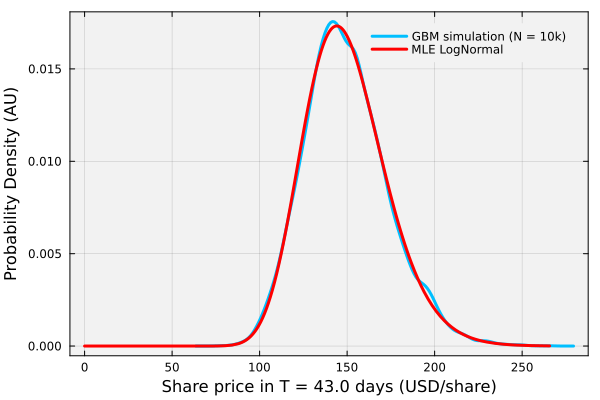

In [28]:
let
    density(endpoint, lw=3, c=:deepskyblue1, label="GBM simulation (N = 10k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### TODO: Future share price projection using the implied volatility
Alternatively, we could use the implied volatility to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where mean $\mu_{IV} = S_{\circ}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{\circ}$ for short duration contracts, and standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). This is only an `approximate model` of the future share price; it has a couple of issues: 
* __The most significant issue__: this model assumes a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal), which is problematic because it can emit negative share prices.

However, this model is widely used to generate quick estimates of future share price ranges using the forward-looking implied volatility. Let's save the Normal IV distribution distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable:

In [30]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(IV/100)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 65 days.`  
* __Summary__: The log-normal gbm share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the normal IV distribution (red line) is symmetric around the initial share price $S_{\circ}$ = `178.0 USD/share` and can admit negative share prices, albeit with a small probability.

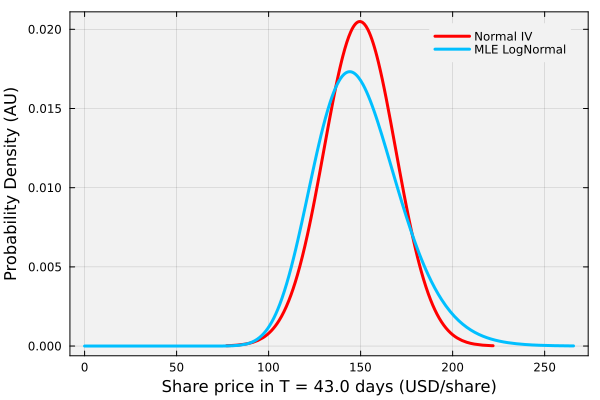

In [32]:
let
    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

## Task 3: Estimate the probability of profit for a AMD put contract
Given the ability to simulate future share price distributions, we can now compute the likelihood of seeing a particular range of values. There are two cases that we consider when exploring the probability of profit: the buyer's and seller's perspectives:
* __Buyer's perspective__: the `AMD` share price `T` days from now $S(T)$, must be _less than_ the breakeven price $B_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated directly from the [cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $F_{S}(B_{p}) = P(S_{T}\leq{B}_{p})$.
* __Seller's perspective__: the `AMD` share price `T` days from now $S(T)$, must be _greater than_ the breakeven price $B_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated from the [complementary cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $P(S_{T}>{B}_{p}) = 1 - F_{S}(B_{p})$.

We can query the [cumulative distribution function $F_{S}(B_{p})$]() using for the projected geometric Brownian motion distribution `d_gbm` and the Implied Volatility price distribution `d_IV` using the [cdf(...) function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

### TODO: Probability of profit (PoP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for a `AMD` put option using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 
* __Summary__: The geometric Brownian motion price distribution estimate is the closest to the reported probability of profit from both the seller's and buyer's perspective (approximately a `1%` error or less in each case). The implied volatility model, despite its restrictive assumptions, is also similar to the observed value. However, it underestimates the probability of profit in the case of the buyer and overestimates in the case of the seller.

In [35]:
let 
    table_df = DataFrame()

    # buyer -
    MPOP = (cdf(d_IV, B) + cdf(d_gbm, B))/2;
    buyer_row_df = (
        sense = "buyer",
        ticker = "AMD",
        DTE = DTE,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_IV = cdf(d_IV, B),
        POP_GBM = cdf(d_gbm, B),
        MPOP = MPOP,
        POP_observed = 1 - POP,
        Δ_error_pct_MPOP = ((MPOP - (1-POP))/((1-POP)))*100,
    );
    push!(table_df, buyer_row_df)
    
    # seller -
    MPOP = ((1 - cdf(d_IV, B)) + (1 - cdf(d_gbm, B)))/2;
    seller_row_df = (
        sense = "seller",
        ticker = "AMD",
        DTE = DTE,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_IV = 1 - cdf(d_IV, B),
        POP_GBM = 1 - cdf(d_gbm, B),
        MPOP = MPOP,
        POP_observed = POP,
        Δ_error_pct_MPOP = ((MPOP - POP)/(POP))*100,
    );
    push!(table_df, seller_row_df)
end

Row,sense,ticker,DTE,Sₒ,K,B,POP_IV,POP_GBM,MPOP,POP_observed,Δ_error_pct_MPOP
,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,buyer,AMD,43.0,148.82,145.0,139.42,0.300906,0.357163,0.329034,0.3175,3.63284
2,seller,AMD,43.0,148.82,145.0,139.42,0.699094,0.642837,0.670966,0.6825,-1.69


### TODO: Compute `Delta` for a Long Put
We know that `Delta` measures the rate of change in the option's premium $\mathcal{P}_{\star}$ with respect to a `+1 USD/share` change in the underlying asset's price. However, we mentioned that one of the secret lives of $\Delta$ is its connection with the probability of profit. Let's explore this connection. 

If we dig around a little on the Internet, we find this idea:

* __Probability of Being In-the-Money (ITM)__: The absolute value of `Delta` can be interpreted as an _estimate_ of the probability that an option will expire ITM. For example, a delta of 0.40 suggests a 40% chance that the option will finish ITM at expiration. 

Let's explore this idea with our `AMD` put option by computing `Delta`.
* We estimate $\Delta$ using the [delta(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta). The [delta(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta) takes several arguments: the `call_option_model` instance, and parameters used to compute the risk-neutral binomial share price tree, e.g., the number of tree levels `h,` the current share price  `Sₒ,` the number of days to expiration `T,` etc.
* The [delta(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta) and returns a value for `Delta.` We store the estimated value for `Delta` in the `delta_long_put::Float64` variable:

In [37]:
delta_long_put = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = put_option_model; # alias the contract model

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

-0.3689999999999998

### Check: Do the Delta's match?

In [73]:
error = ((abs(delta_long_put) - Δ_observed_short_put)/(Δ_observed_short_put))*100

-3.352540597171347

### Build Delta table
Fill me in

In [110]:
let
    df = DataFrame();
    ϵ = 0.01; # 1/100 USD/share

    buyer_row = (
        perspective = "buyer",
        OTM = 1-cdf(d_IV, K),
        ITM = cdf(d_IV, K-ϵ),
        itmobs = Δ_observed_short_put
    )
    push!(df, buyer_row);

    seller_row = (
        perspective = "seller",
        OTM = cdf(d_IV, K-ϵ),
        ITM = 1 - cdf(d_IV, K),
        itmobs = 1 - Δ_observed_short_put
    );
    push!(df, seller_row);

    # show -
    df
end

Row,perspective,OTM,ITM,itmobs
,String,Float64,Float64,Float64
1,buyer,0.592954,0.406847,0.3818
2,seller,0.406847,0.592954,0.6182


__From the buyer's perspective__: the probability that a put contract will expire in the money (ITM), i.e., the share price at expiration is $S_{T} \leq K-\epsilon$ at expiration where $\epsilon=$ `0.01` USD/share is given by $F_{S}(K-\epsilon)$:

In [41]:
cdf(d_IV, K-(1/100)) # buyer's perspective: probability in the money (ITM) (use the IV distribution)

0.40684659919951943

while the probability that we expire at or out of the money (OTM), i.e., $S_{T} > K+\epsilon$ is given by $1-F_{S}(K+\epsilon)$:

In [43]:
1 - cdf(d_IV, K) # buyer's perspective: probability out of the money (OTM) (use the IV distribution)

0.5929540635591573

__From the sellers's perspective__: the probability that a short put contract will expire at or in the money (ITM), i.e., the share price at expiration is $S_{T} \geq K$ at expiration is given by $1 - F_{S}(K)$:

In [45]:
1 - cdf(d_IV, K) # Sellers's perspective: probability in the money (ITM) S ≥ K (use the IV distribution)

0.5929540635591573

while the probability that the we expire out of the money (OTM), i.e., $S_{T}<K-\epsilon$ is given by $F_{S}(K-\epsilon)$:

In [47]:
cdf(d_IV, K-(1/100)) # sellers perspective: probability out of the money (OTM) (use the IV distribution)

0.40684659919951943

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.